In [1]:
from typing import List
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
from pathlib import Path

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 20})

In [2]:
MAIN_DIR = Path("../../../../")

plot_dir = MAIN_DIR / "plots/BiasTest/run3-bdt-may9-msd40-v2"
plot_dir.mkdir(exist_ok=True, parents=True)

In [40]:
cards_dir = "run3-bdt-may9-msd40-v2-ntf012"
biases = [0, 1]
samples = ["sm"]

passbin = 1

if passbin == 0:
    category = "Combined"
else:
    category = f"Bin {passbin}"

if passbin == 2:
    r_bounds = [-30, 40]
elif passbin == 3:
    r_bounds = [-150, 200]
else:
    r_bounds = [-15, 20]

In [41]:
r_dict = {}

for sample in samples:
    if sample not in r_dict:
        r_dict[sample] = {}

    for bias in biases:
        if bias in r_dict[sample]:
            continue

        print(sample, bias)
        file_names = f"/uscms/home/jduarte1/nobackup/HH4b/src/HH4b/cards/{cards_dir}/higgsCombinebias{bias}_passbin{passbin}.FitDiagnostics.mH125.*.root"
        file = uproot.concatenate(file_names)

        r = np.array(file.limit)[::4]
        neg_lim = np.array(file.limit)[1::4]
        pos_lim = np.array(file.limit)[2::4]
        r_negerr = r - neg_lim
        r_poserr = pos_lim - r
        reldiff = r - bias
        reldiff[reldiff < 0] = (reldiff / r_poserr)[reldiff < 0]
        reldiff[reldiff > 0] = (reldiff / r_negerr)[reldiff > 0]

        r_dict[sample][bias] = {
            "r": r,
            "reldiff": reldiff,
            "neg_lim": neg_lim,
            "pos_lim": pos_lim,
        }

sm 0
sm 1


In [42]:
# checking in how many fits the ±r values are at the parameter boundary i.e. they are unreliable
for sample in samples:
    print(sample)
    for i, bias in enumerate(biases):
        num_toys = len(r_dict[sample][bias]["r"])

        print(
            f"For r = {bias}, # of successful fits: = {num_toys}, {np.sum(r_dict[sample][bias]['neg_lim'] == r_bounds[0]) / num_toys * 100:.0f}% of these with r- = {r_bounds[0]}, {np.sum(r_dict[sample][bias]['pos_lim'] == r_bounds[1]) / num_toys * 100 :.0f}% with r+ = {r_bounds[1]}"
        )

sm
For r = 0, # of successful fits: = 99, 13% of these with r- = -15, 7% with r+ = 20
For r = 1, # of successful fits: = 98, 10% of these with r- = -15, 12% with r+ = 20


In [43]:
# checking in how many fits the ±r values are at the parameter boundary AND that side is the one we care about
for sample in samples:
    print(sample)
    for i, bias in enumerate(biases):
        num_toys = len(r_dict[sample][bias]["r"])
        r_lims_bounds = (
            (r_dict[sample][bias]["reldiff"] < 0)
            * (np.isclose(r_dict[sample][bias]["pos_lim"], r_bounds[1]))
        ) + (
            (r_dict[sample][bias]["reldiff"] > 0)
            * (np.isclose(r_dict[sample][bias]["neg_lim"], r_bounds[0]))
        )

        r_lims_wrong = r_dict[sample][bias]["pos_lim"] == r_dict[sample][bias]["neg_lim"]

        tot_pfail = np.sum(r_lims_bounds + r_lims_wrong)

        print(
            f"For r = {bias}, # of successful fits: = {num_toys}, {tot_pfail / num_toys * 100:.0f}% of these with r-lim at boundary"
        )

sm
For r = 0, # of successful fits: = 99, 3% of these with r-lim at boundary
For r = 1, # of successful fits: = 98, 4% of these with r-lim at boundary


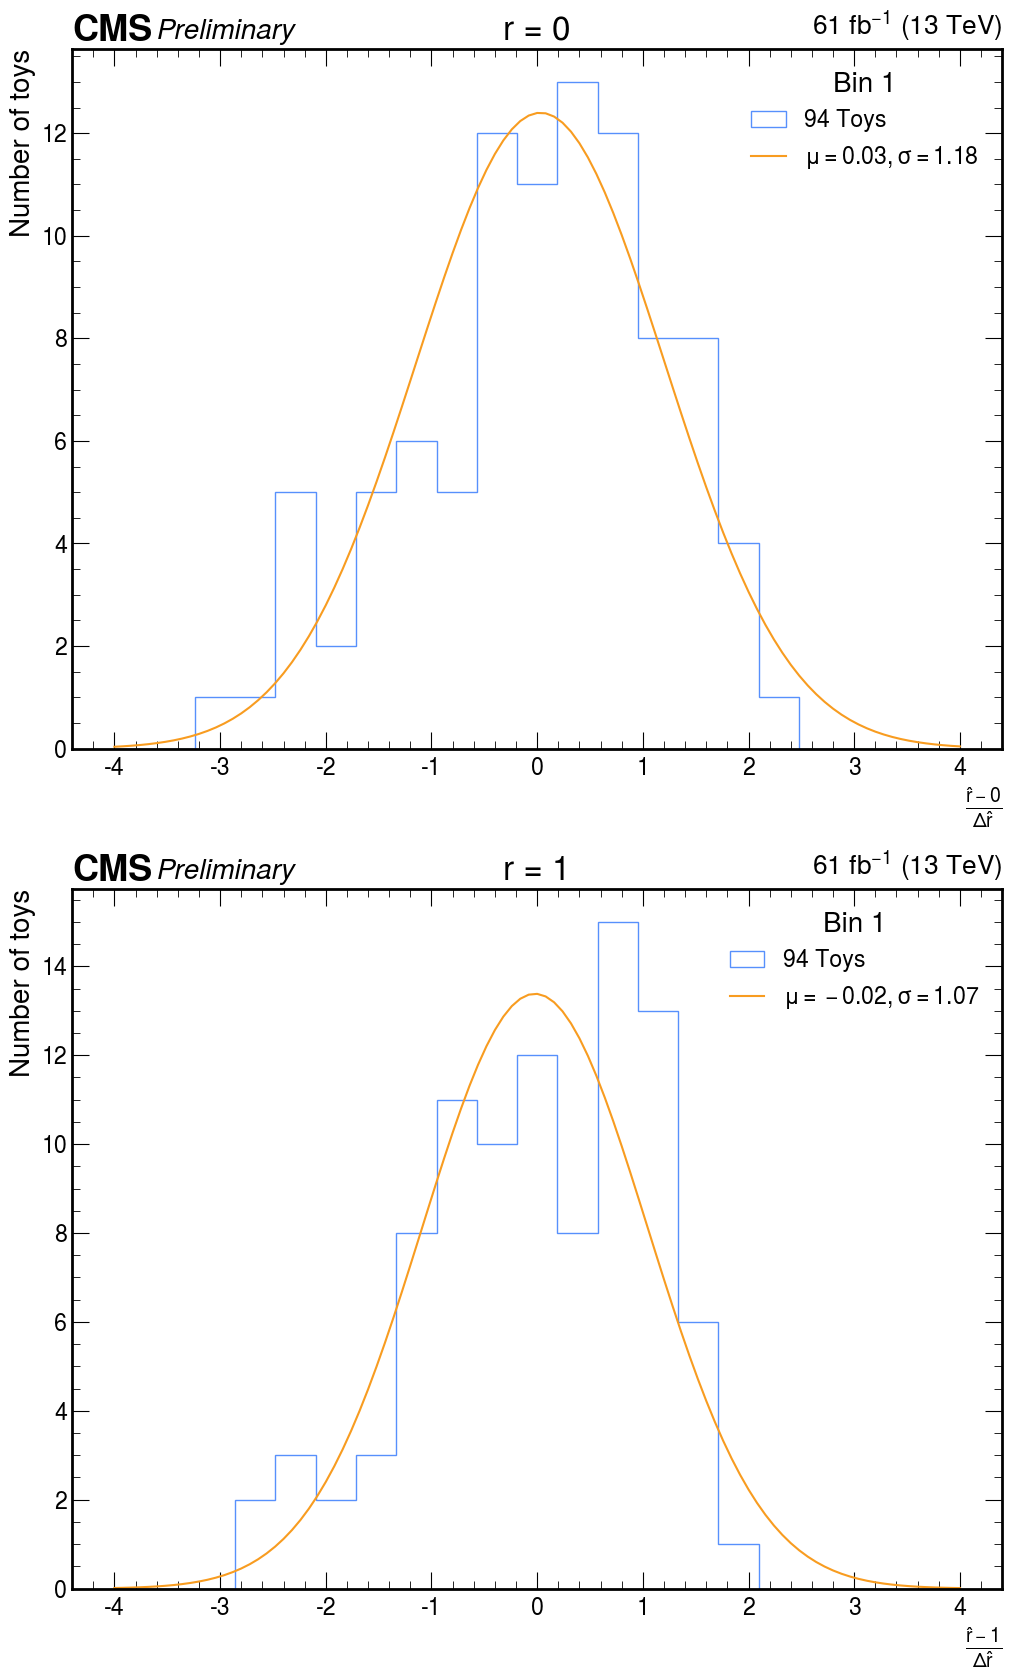

In [44]:
from scipy import stats

xrange = 4
bins = 21
x = np.linspace(-xrange, xrange, 101)

for sample in samples:
    fig, axs = plt.subplots(len(biases), 1, figsize=(12, len(biases) * 10))

    for i, bias in enumerate(biases):
        r_lims_bounds = (
            (r_dict[sample][bias]["reldiff"] < 0)
            * (np.isclose(r_dict[sample][bias]["pos_lim"], r_bounds[1]))
        ) + (
            (r_dict[sample][bias]["reldiff"] > 0)
            * (np.isclose(r_dict[sample][bias]["neg_lim"], r_bounds[0]))
        )

        r_lims_same = r_dict[sample][bias]["pos_lim"] == r_dict[sample][bias]["neg_lim"]

        fit_fail = r_lims_bounds + r_lims_same

        r = r_dict[sample][bias]["r"][~fit_fail]
        reldiff = r_dict[sample][bias]["reldiff"][~fit_fail]
        reldiff = reldiff[(reldiff > -xrange) * (reldiff < xrange)]

        mu, sigma = np.mean(reldiff), np.std(reldiff)

        ax = axs[i] if len(biases) > 1 else axs

        ax.hist(
            reldiff,
            np.linspace(-xrange, xrange, bins + 1),
            histtype="step",
            label=f"{len(reldiff)} Toys",
        )
        ax.plot(
            x,
            # scale by bin width
            stats.norm.pdf(x, loc=mu, scale=sigma) * len(r) * (2 * xrange / bins),
            label=rf"$\mu = {mu:.2f}, \sigma = {sigma:.2f}$",
        )
        ax.set_xlabel(rf"$\frac{{\hat{{r}} - {bias}}}{{\Delta \hat r}}$")
        ax.set_ylabel("Number of toys")
        ax.set_title(f"r = {bias}")
        ax.legend(title=category)

        hep.cms.label(
            "Preliminary",
            ax=ax,
            data=True,
            lumi=61,
            year=None,
        )

    plt.savefig(f"{plot_dir}/{sample}_{category.lower().replace(' ','')}.pdf", bbox_inches="tight")
    plt.show()

    # break